In [35]:
# Detecting suspicious communication specificly (cyber bulling, threatning, terirosim ) from any type of txt data

### TO-DO
----------
Modello:
- ~~k-Cross-validation~~
- ridistribuire-dati (10 sospetto 10 non-sospetto)
  - questo devo lavorare sui dati dal di fuori con uno script python, cercare di prendere dati 50/50
- random-under-sampler
- ~~serializzare il modello - pickle~~

Estensione:
- salvare anche i dati che leggo
- in modo da costruire statistiche


#### Lib
----------
**NLTK** is a leading platform for building Python programs to work with human language data. The Natural Language Toolkit (NLTK) is an open source Python library for Natural Language Processing.

**sklearn** is a free software machine learning library for the Python programming language, it features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN.

**Seaborn** is a Python data visualization library based on matplotlib.

**pandas** 

**numpy**

In [36]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from nltk.corpus import stopwords
import pickle
import matplotlib.pyplot as plt

import re, os
for dirname, _, filenames in os.walk('data/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/dataset/nytimes.csv
data/dataset/suspicious-tweets.csv
data/dataset/result.csv
data/dataset/guardian.csv


In [37]:
df = pd.read_csv('data/dataset/suspicious-tweets.csv')

df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        6145   6133  @mangaaa I hope they will increase the capacit...    2
1       53855  53574                            @chromachris  Clean Me!    7

In [38]:
# Count the number of characters in each message
df['length'] = df['message'].apply(len)
df.head()

,message,label,length
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1,115
1,is upset that he can't update his Facebook by ...,1,111
2,@Kenichan I dived many times for the ball. Man...,1,89
3,my whole body feels itchy and like its on fire,0,47
4,"@nationwideclass no, it's not behaving at all....",1,111


In [39]:
# Use for pre-test only 11 number of elements!
df_labels = df['label']
df_labels.head()

0    1
1    1
2    1
3    0
4    1
Name: label, dtype: int64

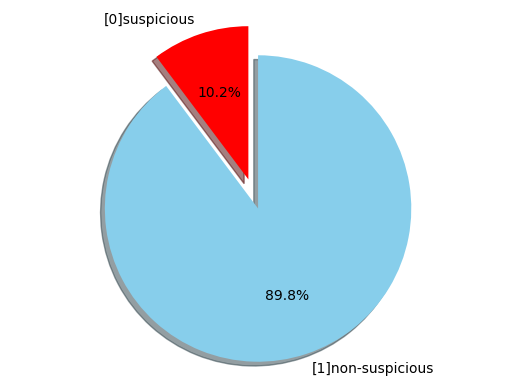

In [40]:
# Only for hinstogram
count_Class = pd.value_counts(df.label, sort = True)

# Data
labels = '[0]suspicious', '[1]non-suspicious'
sizes = [count_Class[0], count_Class[1]]
colors = ['red', 'skyblue']
explode = (0.1, 0.1)


plt.pie(sizes, explode = explode, labels = labels, colors = colors,
        autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.axis('equal')
plt.show()

In [41]:
# Preprocess text and clean string
def preprocess_text(sen):
    sentence = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)',' ',sen) # Removing html tags
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) # Remove punctuations and numbers
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # Single character removal
    sentence = re.sub(r'\s+', ' ', sentence) # Removing multiple spaces
    sentence = sentence.replace("ain't", "am not").replace("aren't", "are not")
    sentence = ' '.join(text.lower() for text in sentence.split(' ')) # Lowering cases
    sw = stopwords.words('english')
    sentence = ' '.join(text for text in sentence.split() if text not in sw) #removing stopwords
    #sentence = ' '.join(text.lemmatize() for text in sentence.split()) #lemmatization
    return sentence

#### Lib
--------------
The **Porter stemming** algorithm (or 'Porter stemmer') is a process for removing the commoner morphological and inflexional endings from words in English. Its main use is as part of a term normalisation process that is usually done when setting up Information Retrieval systems.

In [42]:
# Save in message, clean text
df['message'] = df.message.apply(preprocess_text)
# Tokenization each text
df['message'] = df['message'].apply(nltk.word_tokenize)

stemmer = PorterStemmer()
df['message'] = df['message'].apply(lambda x: [stemmer.stem(y) for y in x])

In [43]:
# is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
# -> ['upset', 'updat', 'facebook', 'text', 'might', 'cri', 'result', 'school', 'today', 'blah']
show = df['message']
show.head()

0    [switchfoot, bummer, shoulda, got, david, carr...
1                       [upset, updat, facebook, text]
2    [kenichan, dive, mani, time, ball, manag, save...
3               [whole, bodi, feel, itchi, like, fire]
4                   [nationwideclass, behav, mad, see]
Name: message, dtype: object

Lib
-------------------
**CountVectorizer**
Convert a collection of text documents to a matrix of token counts.

This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.

If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.

**TfidfTransformer**
Transform a count matrix to a normalized tf or tf-idf representation.

Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [44]:
df['message'] = df['message'].apply(lambda x: ' '.join(x))

# Convert a collection of text documents to a matrix of token counts.
count_vect = CountVectorizer()
counts = count_vect.fit_transform(df['message']);

In [45]:
transformer = TfidfTransformer().fit(counts)
counts = transformer.fit_transform(counts)

In [46]:
# Separe dataset in traning and test(30%)
X_train, X_test, y_train, y_test = train_test_split(counts, df['label'], test_size=0.3, random_state=69)

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [48]:
# implementing naive bayes
NB = MultinomialNB().fit(X_train, y_train)

predicted = NB.predict(X_test)
print(np.mean(predicted == y_test))

0.9002222222222223


In [49]:
from sklearn.metrics import accuracy_score

# Confronto etichette corrette dei dati di test (y) con le risposte elaborate dal programma (predicted).
error = accuracy_score(y_test, predicted)
print(f"Accuracy: {error}")

Accuracy: 0.9002222222222223


In [50]:
report = classification_report(y_test,predicted)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.04      0.08      1869
           1       0.90      1.00      0.95     16131

    accuracy                           0.90     18000
   macro avg       0.95      0.52      0.51     18000
weighted avg       0.91      0.90      0.86     18000



In [51]:
# Compute confusion matrix to evaluate the accuracy of a classification
print(confusion_matrix(y_test, predicted))

[[   73  1796]
 [    0 16131]]


### SVM
----------
Le macchine vettoriali di supporto (SVM) sono un insieme di metodi di apprendimento supervisionato utilizzati per la classificazione, la regressione e il rilevamento di anomalie.

I vantaggi delle macchine a vettori di supporto sono
- Efficaci in spazi ad alta dimensionalità.
- Sono ancora efficaci nei casi in cui il numero di dimensioni è maggiore del numero di campioni.
- Utilizza un sottoinsieme di punti di addestramento nella funzione di decisione (chiamati vettori di supporto), quindi è anche efficiente dal punto di vista della memoria.
- Versatile: è possibile specificare diverse funzioni kernel per la funzione di decisione. Vengono forniti kernel comuni, ma è anche possibile specificare kernel personalizzati.

Gli svantaggi delle macchine vettoriali di supporto sono i seguenti:
- Se il numero di caratteristiche è molto maggiore del numero di campioni, è fondamentale evitare l'over-fitting nella scelta delle funzioni Kernel e del termine di regolarizzazione.
- Le SVM non forniscono direttamente stime di probabilità, che vengono calcolate utilizzando una costosa convalida incrociata a cinque volte (vedere Punteggi e probabilità, più avanti).
Le macchine vettoriali di supporto in scikit-learn supportano come input vettori campione sia densi (numpy.ndarray e convertibili in numpy.asarray) che radi (qualsiasi scipy.sparse). Tuttavia, per utilizzare una SVM per fare previsioni su dati sparsi, è necessario che sia stata adattata a tali dati. Per ottenere prestazioni ottimali, utilizzare numpy.ndarray ordinati in C (densi) o scipy.sparse.csr_matrix (radi) con dtype=float64.

In [52]:
# implementing SVM
sv = SVC().fit(X_train, y_train)

predicted = sv.predict(X_test)
print(np.mean(predicted == y_test))

0.9588888888888889


In [53]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1869
           1       0.96      1.00      0.98     16131

    accuracy                           0.96     18000
   macro avg       0.96      0.81      0.87     18000
weighted avg       0.96      0.96      0.95     18000



### Confusion matrix
------------
Compute confusion matrix to evaluate the accuracy of a classification.

By definition a confusion matrix `C` is such that `C_{i, j}` is equal to the number of observations known to be in group `i` and predicted to be in group `j`.

Thus in binary classification, the count of true negatives is `C_{0,0}`, false negatives is `C_{1,0}`, true positives is `C_{1,1}` and false positives is `C_{0,1}`.

##### Return:
`C `: ndarray of shape (n_classes, n_classes)
    Confusion matrix whose `i-th` row and `j-th` column entry indicates the number of samples with true label being `i-th` class and predicted label being `j-th` class.

In [54]:
print(confusion_matrix(y_test, predicted))

[[ 1164   705]
 [   35 16096]]


### Decision tree classifier
------------
Decision tree builds classification or regression models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes.

In [55]:
# implementing disession tree
dt = DecisionTreeClassifier().fit(X_train, y_train)

predicted = dt.predict(X_test)
print(np.mean(predicted == y_test))

0.9727777777777777


In [56]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1869
           1       0.98      0.99      0.98     16131

    accuracy                           0.97     18000
   macro avg       0.94      0.91      0.92     18000
weighted avg       0.97      0.97      0.97     18000



In [57]:
print(confusion_matrix(y_test, predicted))

[[ 1564   305]
 [  185 15946]]


### An AdaBoost classifier
------------
An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

This class implements the algorithm known as AdaBoost-SAMME.

In [58]:
# implementing adabost
ab = AdaBoostClassifier().fit(X_train, y_train)

In [59]:
predicted = ab.predict(X_test)

print(np.mean(predicted == y_test))

0.9655555555555555


In [60]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1869
           1       0.97      1.00      0.98     16131

    accuracy                           0.97     18000
   macro avg       0.96      0.85      0.90     18000
weighted avg       0.97      0.97      0.96     18000



In [61]:
print(confusion_matrix(y_test, predicted))

[[ 1314   555]
 [   65 16066]]


##### Lib
-------------
**Transform** documents to document-term matrix.
Extract token counts out of raw text documents using the vocabulary fitted with fit or the one provided to the constructor.

**Predict** class or regression value for X.
For a classification model, the predicted class for each sample in X is returned. For a regression model, the predicted value based on X is returned.

In [62]:
# converting content to lower case
pred = (df['message'].str.lower())
# printing predictions made by model
print("prediction: {}". format(dt.predict(count_vect.transform(pred.values.astype('U')))))
# saving predictions in a variable
my_pred = dt.predict(count_vect.transform(pred.values.astype('U')))

# saving predicted labels in .csv file
df['autotag'] = my_pred
df.to_csv('data/dataset/result.csv',index = False)

prediction: [1 1 1 ... 1 1 1]


In [63]:
# getting the number of -ve , +ve  predictions 
positive = 0
negative = 0

for v in my_pred:
 if (v == 1):
  positive += 1
 elif (v == 0):
  negative += 1

In [64]:
# function for quality measurement (can be set to required parameters)
def quality(pos,total):
    if((pos*100)/total >= 0 and (pos*100)/total <=24 ):
        print('Quality: Very Negative')
    elif((pos*100)/total >= 25 and (pos*100)/total <=49 ):
        print('Quality: Negative')
    elif((pos*100)/total >= 50 and (pos*100)/total <=74 ):
        print('Quality: Positive')
    elif((pos*100)/total >= 75 and (pos*100)/total <=100 ):
        print('Quality: Very Positive')

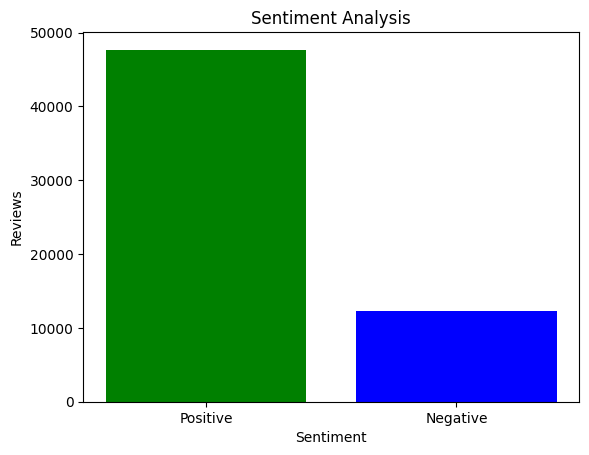

Sentiment - Positive: 47671, Negative: 12329
Quality: Very Positive


In [65]:
# importing library to plot charts
import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [100, 200 ] 
  
# heights of bars 
height = [positive,negative] 
  
# labels for bars 
tick_label = ['Positive', 'Negative'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, width = 80, color = ['green','blue']) 
  
# naming the x-axis 
plt.xlabel('Sentiment') 
# naming the y-axis 
plt.ylabel('Reviews') 
# plot title 
plt.title('Sentiment Analysis') 
  
# function to show the plot 
plt.show() 
print ("Sentiment - Positive: "+str(positive)+", Negative: "+str(negative))
quality(positive,(positive+negative))

In [66]:
# getting negativity 
negativeity = (negative*100)/(positive+negative)
positivity = (positive*100)/(positive+negative)
print("Negativeity: "+str(negativeity)+"%")
print("Positivity: "+str(positivity)+"%")

Negativeity: 20.548333333333332%
Positivity: 79.45166666666667%


In [76]:
# Implement K fold cross-validation
from sklearn.model_selection import cross_val_score
nb_accuracy = cross_val_score(estimator = NB, X = X_train, y = y_train, cv = 5)
print("[nb] Accuracy: {:.2f} %".format(nb_accuracy.mean()*100))
print("[nb] Standard Deviation: {:.2f} %".format(nb_accuracy.std()*100))

# sv_accuracy = cross_val_score(estimator = sv, X = X_train, y = y_train, cv = 5)
# print("[sv] Accuracy: {:.2f} %".format(sv_accuracy.mean()*100))
# print("[sv] Standard Deviation: {:.2f} %".format(sv_accuracy.std()*100))

# dt_accuracies = cross_val_score(estimator = dt, X = X_train, y = y_train, cv = 5)
# print("[dt] Accuracy: {:.2f} %".format(dt_accuracies.mean()*100))
# print("[dt] Standard Deviation: {:.2f} %".format(dt_accuracies.std()*100))

# ab_accuracies = cross_val_score(estimator = ab, X = X_train, y = y_train, cv = 5)
# print("[ab] Accuracy: {:.2f} %".format(ab_accuracies.mean()*100))
# print("[ab] Standard Deviation: {:.2f} %".format(ab_accuracies.std()*100))

[nb] Accuracy: 90.08 %
[nb] Standard Deviation: 0.11 %


KeyboardInterrupt: 

In [67]:
# NB = MultinomialNB().fit(X_train, y_train)
# sv = SVC().fit(X_train, y_train)
# dt = DecisionTreeClassifier().fit(X_train, y_train)
# ab = AdaBoostClassifier().fit(X_train, y_train)

nb_fileModel = 'data/modelSave/nb_model.sav'
sv_fileModel = 'data/modelSave/sv_model.sav'
dt_fileModel = 'data/modelSave/dt_model.sav'
ab_fileModel = 'data/modelSave/ab_model.sav'

pickle.dump(NB, open(nb_fileModel, 'wb'))
pickle.dump(sv, open(sv_fileModel, 'wb'))
pickle.dump(dt, open(dt_fileModel, 'wb'))
pickle.dump(ab, open(ab_fileModel, 'wb'))


In [74]:
nb_loaded_model = pickle.load(open(nb_fileModel, 'rb'))
sv_loaded_model = pickle.load(open(sv_fileModel, 'rb'))
dt_loaded_model = pickle.load(open(dt_fileModel, 'rb'))
ab_loaded_model = pickle.load(open(ab_fileModel, 'rb'))

# Predicting the Test set results
nb_pred = nb_loaded_model.predict(X_test)
print("MultinomialNB: ", nb_loaded_model.score(X_test, y_test))

sv_pred = sv_loaded_model.predict(X_test)
print("SVC: ", sv_loaded_model.score(X_test, y_test))

dt_pred = dt_loaded_model.predict(X_test)
print("DecisionTreeClassifier: ", dt_loaded_model.score(X_test, y_test))

ab_pred = ab_loaded_model.predict(X_test)
print("AdaBoostClassifier: ", ab_loaded_model.score(X_test, y_test))

MultinomialNB:  0.9002222222222223
SVC:  0.9588888888888889
DecisionTreeClassifier:  0.9727777777777777
AdaBoostClassifier:  0.9655555555555555
